In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import os

# Spectrum Bounds Analysis

In [2]:
def format_lambda_latex(lamb):
    """Format lambda value as LaTeX 10^{x} notation."""
    import math
    if lamb == 0:
        return r'$0$'
    exp = int(round(math.log10(lamb)))
    return rf'$10^{{{exp}}}$'

In [3]:
def add_theory_band(ax, experiments, min_lambda=None):
    """
    Add theoretical slope band (ε ∝ 1/√(m/d_λ)) to an axis.

    Args:
        ax: Matplotlib axis
        experiments: List of experiment dictionaries with 'm_over_d_lambda' and 'empirical_eps_95'
        min_lambda: Optional minimum lambda threshold to filter experiments
    """
    # Filter experiments if threshold is specified
    filtered_experiments = [e for e in experiments if min_lambda is None or e["lambda"] >= min_lambda]
    all_m_ratio = np.array([e["m_over_d_lambda"] for e in filtered_experiments])
    all_eps = np.array([e["empirical_eps_95"] for e in filtered_experiments])
    mask = np.isfinite(all_m_ratio) & np.isfinite(all_eps) & (all_m_ratio > 0) & (all_eps > 0)
    x_clean, y_clean = all_m_ratio[mask], all_eps[mask]

    if len(x_clean) > 0:
        x_theory = np.logspace(np.log10(x_clean.min()), np.log10(x_clean.max()), 100)
        # Show band of theoretical lines with different constants
        C_med = np.median(y_clean * np.sqrt(x_clean))
        # Extended range with same density (more lines, wider spread)
        # ~6 lines per decade, spanning from 0.001x to 1000x (6 decades = ~36 lines)
        factors = np.logspace(np.log10(0.001), np.log10(1000), 40)
        for factor in factors:
            # Fade alpha towards edges
            dist_from_center = abs(np.log10(factor))
            alpha = 0.18 * np.exp(-0.15 * dist_from_center)  # Slower fade for extended range
            y_theory = (C_med * factor) / np.sqrt(x_theory)
            ax.loglog(x_theory, y_theory, 'k-', alpha=alpha, linewidth=0.8)
        # Add the main reference line
        ax.loglog(x_theory, C_med / np.sqrt(x_theory), 'k--', linewidth=2, alpha=0.7)

        # Store info for annotation (will be added after layout)
        ax._theory_annotation_info = {
            'C_med': C_med,
            'x_theory': x_theory,
        }


def add_theory_annotation_single(fig, ax):
    """Add annotation with correct slope after figure layout is finalized (for single axis)."""
    fig.canvas.draw()

    if not hasattr(ax, '_theory_annotation_info'):
        return

    info = ax._theory_annotation_info
    C_med = info['C_med']
    x_theory = info['x_theory']

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x_at_bottom = (C_med / ylim[0]) ** 2
    y_at_right = C_med / np.sqrt(xlim[1])

    if x_at_bottom <= xlim[1]:
        annot_y = ylim[0] * 1.5
        annot_x = (C_med / annot_y) ** 2
    else:
        annot_x = xlim[1] / 5
        annot_y = C_med / np.sqrt(annot_x)

    x1, x2 = x_theory[50], x_theory[70]
    y1 = C_med / np.sqrt(x1)
    y2 = C_med / np.sqrt(x2)

    disp1 = ax.transData.transform((x1, y1))
    disp2 = ax.transData.transform((x2, y2))

    dx = disp2[0] - disp1[0]
    dy = disp2[1] - disp1[1]
    angle_deg = np.degrees(np.arctan2(dy, dx))

    ax.annotate(r'$\epsilon \propto 1/\sqrt{m/d_\lambda}$',
                xy=(annot_x, annot_y), fontsize=12,
                ha='center', va='bottom',
                xytext=(0, 3),
                textcoords='offset points',
                rotation=angle_deg,
                rotation_mode='anchor')


def add_theory_annotations(fig, axes):
    """Add annotations with correct slope after figure layout is finalized."""
    # Need to draw first to get accurate transforms
    fig.canvas.draw()

    for ax in axes.flat:
        if not hasattr(ax, '_theory_annotation_info'):
            continue

        info = ax._theory_annotation_info
        C_med = info['C_med']
        x_theory = info['x_theory']

        # Get current axis limits
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # The line y = C/sqrt(x) exits the visible region at one of two points:
        # 1. Bottom exit: where y = ylim[0], giving x = (C/ylim[0])^2
        # 2. Right exit: where x = xlim[1], giving y = C/sqrt(xlim[1])
        #
        # We place the annotation at whichever exit is within the visible region.

        x_at_bottom = (C_med / ylim[0]) ** 2  # x where line hits y_min
        y_at_right = C_med / np.sqrt(xlim[1])  # y where line hits x_max

        if x_at_bottom <= xlim[1]:
            # Line exits at bottom - place annotation near bottom
            annot_y = ylim[0] * 1.5  # slightly above bottom
            annot_x = (C_med / annot_y) ** 2
        else:
            # Line exits at right - place annotation near right edge
            annot_x = xlim[1] / 5  # slightly left of right edge
            annot_y = C_med / np.sqrt(annot_x)

        # Compute angle in display coordinates
        # Take two points on the line and transform to display coords
        x1, x2 = x_theory[50], x_theory[70]
        y1 = C_med / np.sqrt(x1)
        y2 = C_med / np.sqrt(x2)

        # Transform data coordinates to display coordinates
        disp1 = ax.transData.transform((x1, y1))
        disp2 = ax.transData.transform((x2, y2))

        # Compute angle from display coordinates
        dx = disp2[0] - disp1[0]
        dy = disp2[1] - disp1[1]
        angle_deg = np.degrees(np.arctan2(dy, dx))

        # Add annotation close to the line with small offset
        ax.annotate(r'$\epsilon \propto 1/\sqrt{m/d_\lambda}$',
                    xy=(annot_x, annot_y), fontsize=12,
                    ha='center', va='bottom',
                    xytext=(0, 3),  # small offset above the line
                    textcoords='offset points',
                    rotation=angle_deg,
                    rotation_mode='anchor')


def format_lambda_latex(lamb):
    """Format lambda value as LaTeX 10^{x} notation."""
    import math
    if lamb == 0:
        return r'0'
    exp = int(round(math.log10(lamb)))
    return rf'10^{{{exp}}}'


# Define a unified set of lambda values and colors for consistent plotting
# Extended to include smaller lambdas (10^{-8}, 10^{-7}) used in some experiments
UNIFIED_LAMBDA_VALUES = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]
UNIFIED_LAMBDA_COLORS = {lamb: plt.cm.viridis(i / (len(UNIFIED_LAMBDA_VALUES) - 1))
                          for i, lamb in enumerate(UNIFIED_LAMBDA_VALUES)}


def get_lambda_color(lamb, lambda_colors=None):
    """Get color for a lambda value, using unified colors if available."""
    if lambda_colors is not None and lamb in lambda_colors:
        return lambda_colors[lamb]
    # Fallback: find closest lambda in unified set
    if UNIFIED_LAMBDA_COLORS:
        closest = min(UNIFIED_LAMBDA_VALUES, key=lambda x: abs(np.log10(x) - np.log10(lamb)) if lamb > 0 else float('inf'))
        return UNIFIED_LAMBDA_COLORS[closest]
    return 'blue'


def create_unified_legend(lambda_values=None, lambda_colors=None, save_path=None, figsize=(12, 0.4),
                          include_m_eq_d=True, fontsize=14):
    """
    Create a unified horizontal legend for lambda values.

    Args:
        lambda_values: List of lambda values to include (default: UNIFIED_LAMBDA_VALUES)
        lambda_colors: Dict mapping lambda -> color (default: UNIFIED_LAMBDA_COLORS)
        save_path: Path to save the legend figure
        figsize: Figure size (width, height)
        include_m_eq_d: Whether to include the m=d_lambda reference line in legend
        fontsize: Font size for legend text

    Returns:
        fig: The legend figure
    """
    if lambda_values is None:
        lambda_values = UNIFIED_LAMBDA_VALUES
    if lambda_colors is None:
        lambda_colors = UNIFIED_LAMBDA_COLORS

    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')

    # Create legend handles (not drawn on figure)
    handles = []
    labels = []

    # Add m = d_lambda reference line first (using Line2D, not axvline)
    if include_m_eq_d:
        h = Line2D([0], [0], color='red', linestyle='--', linewidth=2, alpha=0.8)
        handles.append(h)
        labels.append('$m=d_\\lambda$')

    # Add lambda values
    for lamb in sorted(lambda_values):
        color = lambda_colors.get(lamb, get_lambda_color(lamb, lambda_colors))
        h = Line2D([0], [0], color=color, marker='o', linestyle='-', markersize=6, alpha=0.8)
        handles.append(h)
        labels.append(f'$\\lambda={format_lambda_latex(lamb)}$')

    # Create horizontal legend
    legend = ax.legend(handles, labels, loc='center', ncol=len(handles),
                       fontsize=fontsize, frameon=False,
                       handletextpad=0.3, columnspacing=1.5)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved legend to {save_path}")

    plt.show()
    return fig


def plot_bilinear_form_error(dataset, model, proj_type="sjlt", results_dir="./results/spectrum_bounds",
                              min_lambda=None, show_ci=True, ci_alpha=0.2, figsize=(9, 6), save_path=None,
                              show_ylabel=True, show_legend=True, lambda_colors=None):
    """
    Plot bilinear form error (top-right plot from the original 2x2 grid).

    Validates Theorem 1 Eq (2): |B̃_λ(g,g') - B_λ(g,g')| ≤ ε·√φ_λ(g)·√φ_λ(g')

    Args:
        show_ylabel: Whether to show y-axis label (set False for side-by-side figures)
        show_legend: Whether to show the legend (set False when using unified legend)
        lambda_colors: Dict mapping lambda -> color for consistent colors across plots
    """
    test_path = f"{results_dir}/{dataset}_{model}_{proj_type}_test.pt"

    if not os.path.exists(test_path):
        print(f"Test mode results not found: {test_path}")
        return None

    test_results = torch.load(test_path, map_location="cpu", weights_only=False)
    print(f"Loaded test mode results for {dataset}/{model}")

    # Check for per-trial data
    has_per_trial = (len(test_results['experiments']) > 0 and
                     'empirical_eps_95_std' in test_results['experiments'][0])
    if show_ci and has_per_trial:
        num_trials = test_results.get('num_trials', 5)
        t_value = 1.96 if num_trials > 30 else {2: 12.71, 3: 4.30, 4: 3.18, 5: 2.78,
                                                  6: 2.57, 7: 2.45, 8: 2.36, 9: 2.31,
                                                  10: 2.26}.get(num_trials, 2.0)
    elif show_ci:
        show_ci = False

    fig, ax = plt.subplots(figsize=figsize)

    lambda_values = test_results["lambda_values"]
    if min_lambda is not None:
        lambda_values = [l for l in lambda_values if l >= min_lambda]

    # Use unified colors if provided, otherwise fall back to per-plot colors
    if lambda_colors is None:
        lambda_colors = UNIFIED_LAMBDA_COLORS

    # Organize by lambda
    test_by_lambda = {}
    for exp in test_results["experiments"]:
        lamb = exp["lambda"]
        if min_lambda is not None and lamb < min_lambda:
            continue
        if lamb not in test_by_lambda:
            test_by_lambda[lamb] = []
        test_by_lambda[lamb].append(exp)

    ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, alpha=0.8, label='$m = d_\\lambda$')

    all_y_test = []
    for lamb in sorted(lambda_values):
        if lamb not in test_by_lambda:
            continue
        color = get_lambda_color(lamb, lambda_colors)
        exps = sorted(test_by_lambda[lamb], key=lambda x: x["m_over_d_lambda"])
        x = np.array([e["m_over_d_lambda"] for e in exps])
        y = np.array([e["empirical_eps_95"] for e in exps])
        all_y_test.extend(y)

        ax.loglog(x, y, 'o-', color=color, label=format_lambda_latex(lamb), markersize=6, alpha=0.8)

        if show_ci and has_per_trial:
            y_std = np.array([e.get("empirical_eps_95_std", 0) for e in exps])
            n_trials = np.array([e.get("n_trials", num_trials) for e in exps])
            y_se = y_std / np.sqrt(n_trials)
            y_ci = t_value * y_se
            y_lower = np.maximum(y - y_ci, y * 0.01)
            y_upper = y + y_ci
            ax.fill_between(x, y_lower, y_upper, color=color, alpha=ci_alpha)

    add_theory_band(ax, test_results["experiments"], min_lambda)

    if all_y_test:
        ax.set_ylim(min(all_y_test) * 0.5, max(all_y_test) * 2.0)

    ax.set_title(f'{dataset.upper()} + {model.upper()}', fontsize=30)
    # set tick font size
    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.set_xlabel('$m / d_\\lambda$', fontsize=28)
    # Always set y-label to reserve space, but make it invisible if show_ylabel=False
    ylabel_color = 'black' if show_ylabel else 'none'
    ax.set_ylabel(r"$\epsilon$ (95th %ile)", fontsize=28, color=ylabel_color)

    if show_legend:
        ax.legend(fontsize=12)

    plt.tight_layout()
    add_theory_annotation_single(fig, ax)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved figure to {save_path}")

    plt.show()
    return fig


def plot_spectrum(dataset, model, proj_type="sjlt", results_dir="./results/spectrum_bounds", figsize=(9, 6),
                  save_path=None, show_ylabel=True, linewidth=2.5):
    """
    Plot eigenvalue spectrum (bottom-left plot from the original 2x2 grid).

    Args:
        show_ylabel: Whether to show y-axis label (set False for side-by-side figures)
        linewidth: Width of the spectrum line (default 2.5)
    """
    self_path = f"{results_dir}/{dataset}_{model}_{proj_type}_self.pt"

    if not os.path.exists(self_path):
        print(f"Self-influence results not found: {self_path}")
        return None

    self_results = torch.load(self_path, map_location="cpu", weights_only=False)
    print(f"Loaded self-influence results for {dataset}/{model}")

    fig, ax = plt.subplots(figsize=figsize)

    eigenvalues = self_results.get("eigenvalues")
    rank = self_results.get("rank", len(eigenvalues) if eigenvalues is not None else 0)

    if eigenvalues is not None:
        ax.semilogy(eigenvalues[:rank], 'b-', linewidth=linewidth)
        ax.set_xlabel('$i$', fontsize=38)
        # Always set y-label to reserve space, but make it invisible if show_ylabel=False
        ylabel_color = 'black' if show_ylabel else 'none'
        ax.set_ylabel('$\\lambda_i$', fontsize=38, color=ylabel_color)
        # set tick font size
        ax.tick_params(axis='both', which='major', labelsize=28)
        ax.set_title(f'{dataset.upper()} + {model.upper()}', fontsize=30)
    else:
        ax.text(0.5, 0.5, 'Eigenvalues not available',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'Eigenvalue Spectrum: {dataset.upper()} + {model.upper()}')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved figure to {save_path}")

    plt.show()
    return fig

In [4]:
def plot_bilinear_form_error_combined(configs, proj_type="sjlt", results_dir="./results/spectrum_bounds",
                                       min_lambda=None, show_ci=True, ci_alpha=0.2,
                                       figsize=(20, 5), save_path=None, lambda_colors=None, wspace=0.15):
    """
    Plot bilinear form error for multiple dataset-model configs in a single figure.

    Args:
        configs: List of (dataset, model) tuples
        proj_type: Projection type (default: "sjlt")
        results_dir: Directory containing results
        min_lambda: Minimum lambda threshold to filter experiments
        show_ci: Whether to show confidence intervals
        ci_alpha: Alpha for confidence interval shading
        figsize: Figure size (width, height)
        save_path: Path to save the combined figure
        lambda_colors: Dict mapping lambda -> color
        wspace: Width space between subplots (default: 0.15)

    Returns:
        fig: The combined figure
    """
    n_plots = len(configs)
    fig, axes = plt.subplots(1, n_plots, figsize=figsize, sharey=True)

    if n_plots == 1:
        axes = [axes]

    if lambda_colors is None:
        lambda_colors = UNIFIED_LAMBDA_COLORS

    for idx, (dataset, model) in enumerate(configs):
        ax = axes[idx]
        test_path = f"{results_dir}/{dataset}_{model}_{proj_type}_test.pt"

        if not os.path.exists(test_path):
            print(f"Test mode results not found: {test_path}")
            ax.text(0.5, 0.5, 'Data not found', ha='center', va='center', transform=ax.transAxes)
            continue

        test_results = torch.load(test_path, map_location="cpu", weights_only=False)
        print(f"Loaded test mode results for {dataset}/{model}")

        # Check for per-trial data
        has_per_trial = (len(test_results['experiments']) > 0 and
                         'empirical_eps_95_std' in test_results['experiments'][0])
        if show_ci and has_per_trial:
            num_trials = test_results.get('num_trials', 5)
            t_value = 1.96 if num_trials > 30 else {2: 12.71, 3: 4.30, 4: 3.18, 5: 2.78,
                                                      6: 2.57, 7: 2.45, 8: 2.36, 9: 2.31,
                                                      10: 2.26}.get(num_trials, 2.0)
        else:
            has_per_trial = False

        lambda_values = test_results["lambda_values"]
        if min_lambda is not None:
            lambda_values = [l for l in lambda_values if l >= min_lambda]

        # Organize by lambda
        test_by_lambda = {}
        for exp in test_results["experiments"]:
            lamb = exp["lambda"]
            if min_lambda is not None and lamb < min_lambda:
                continue
            if lamb not in test_by_lambda:
                test_by_lambda[lamb] = []
            test_by_lambda[lamb].append(exp)

        ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, alpha=0.8)

        all_y_test = []
        for lamb in sorted(lambda_values):
            if lamb not in test_by_lambda:
                continue
            color = get_lambda_color(lamb, lambda_colors)
            exps = sorted(test_by_lambda[lamb], key=lambda x: x["m_over_d_lambda"])
            x = np.array([e["m_over_d_lambda"] for e in exps])
            y = np.array([e["empirical_eps_95"] for e in exps])
            all_y_test.extend(y)

            ax.loglog(x, y, 'o-', color=color, markersize=6, alpha=0.8)

            if show_ci and has_per_trial:
                y_std = np.array([e.get("empirical_eps_95_std", 0) for e in exps])
                n_trials = np.array([e.get("n_trials", num_trials) for e in exps])
                y_se = y_std / np.sqrt(n_trials)
                y_ci = t_value * y_se
                y_lower = np.maximum(y - y_ci, y * 0.01)
                y_upper = y + y_ci
                ax.fill_between(x, y_lower, y_upper, color=color, alpha=ci_alpha)

        add_theory_band(ax, test_results["experiments"], min_lambda)

        if all_y_test:
            ax.set_ylim(min(all_y_test) * 0.5, max(all_y_test) * 2.0)

        ax.set_title(f'{dataset.upper()} + {model.upper()}', fontsize=24)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_xlabel('$m / d_\\lambda$', fontsize=22)

    # Add shared y-label on the left
    axes[0].set_ylabel(r"$\epsilon$ (95th %ile)", fontsize=22)

    plt.tight_layout()
    plt.subplots_adjust(wspace=wspace)

    # Add theory annotations after layout
    add_theory_annotations(fig, np.array(axes))

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved combined figure to {save_path}")

    plt.show()
    return fig


def plot_spectrum_combined(configs, proj_type="sjlt", results_dir="./results/spectrum_bounds",
                           figsize=(20, 5), save_path=None, linewidth=3.5, wspace=0.15):
    """
    Plot eigenvalue spectrum for multiple dataset-model configs in a single figure.

    Args:
        configs: List of (dataset, model) tuples
        proj_type: Projection type (default: "sjlt")
        results_dir: Directory containing results
        figsize: Figure size (width, height)
        save_path: Path to save the combined figure
        linewidth: Width of the spectrum line
        wspace: Width space between subplots (default: 0.15)

    Returns:
        fig: The combined figure
    """
    n_plots = len(configs)
    fig, axes = plt.subplots(1, n_plots, figsize=figsize, sharey=True)

    if n_plots == 1:
        axes = [axes]

    for idx, (dataset, model) in enumerate(configs):
        ax = axes[idx]
        self_path = f"{results_dir}/{dataset}_{model}_{proj_type}_self.pt"

        if not os.path.exists(self_path):
            print(f"Self-influence results not found: {self_path}")
            ax.text(0.5, 0.5, 'Data not found', ha='center', va='center', transform=ax.transAxes)
            continue

        self_results = torch.load(self_path, map_location="cpu", weights_only=False)
        print(f"Loaded self-influence results for {dataset}/{model}")

        eigenvalues = self_results.get("eigenvalues")
        rank = self_results.get("rank", len(eigenvalues) if eigenvalues is not None else 0)

        if eigenvalues is not None:
            ax.semilogy(eigenvalues[:rank], 'b-', linewidth=linewidth)
            ax.set_xlabel('$i$', fontsize=28)
            ax.tick_params(axis='both', which='major', labelsize=20)
            ax.set_title(f'{dataset.upper()} + {model.upper()}', fontsize=24)
        else:
            ax.text(0.5, 0.5, 'Eigenvalues not available',
                    ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{dataset.upper()} + {model.upper()}', fontsize=24)

    # Add shared y-label on the left
    axes[0].set_ylabel('$\\lambda_i$', fontsize=28)

    plt.tight_layout()
    plt.subplots_adjust(wspace=wspace)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved combined figure to {save_path}")

    plt.show()
    return fig

Plotting Combined Bilinear Form Error
Loaded test mode results for mnist/lr
Loaded test mode results for mnist/mlp
Loaded test mode results for cifar2/resnet9
Saved combined figure to ./figures/spectrum_bounds/bilinear_combined.pdf


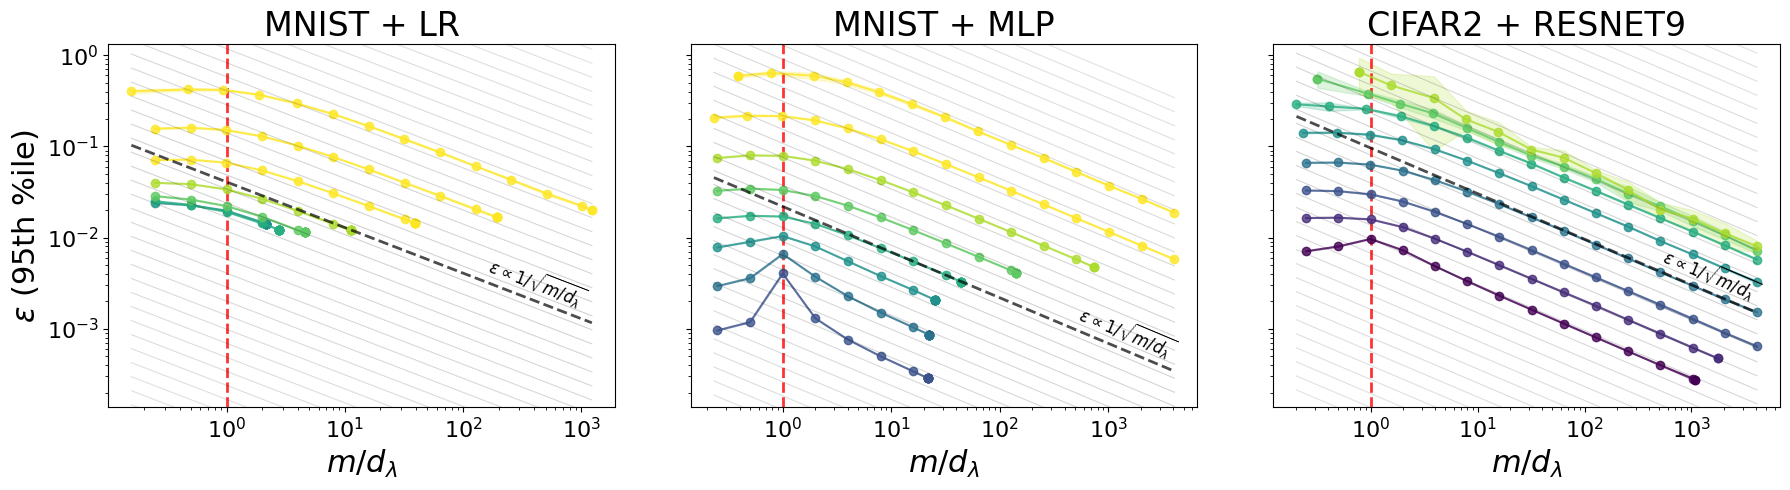


Generating Unified Legend
Saved legend to ./figures/spectrum_bounds/bilinear_legend.pdf


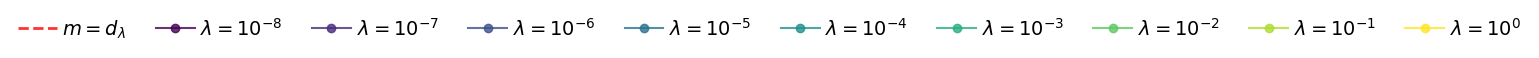


Plotting Combined Eigenvalue Spectrum
Loaded self-influence results for mnist/lr
Loaded self-influence results for mnist/mlp
Loaded self-influence results for cifar2/resnet9
Saved combined figure to ./figures/spectrum_bounds/spectrum_combined.pdf


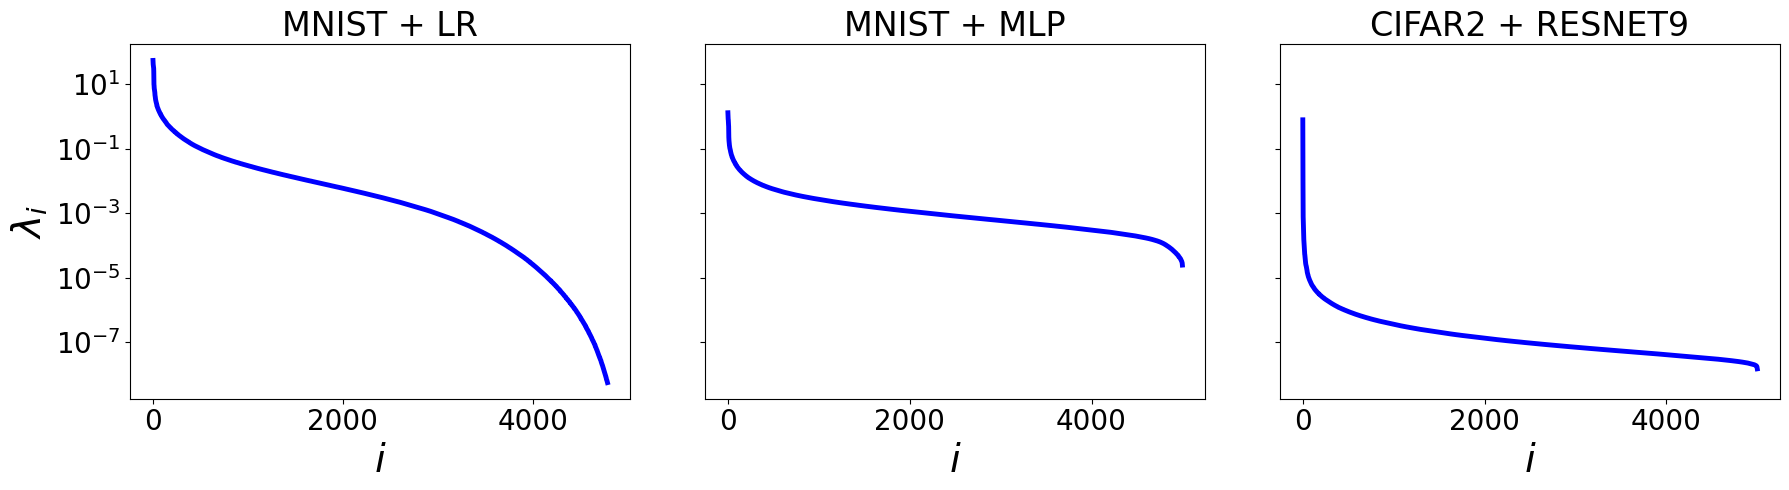

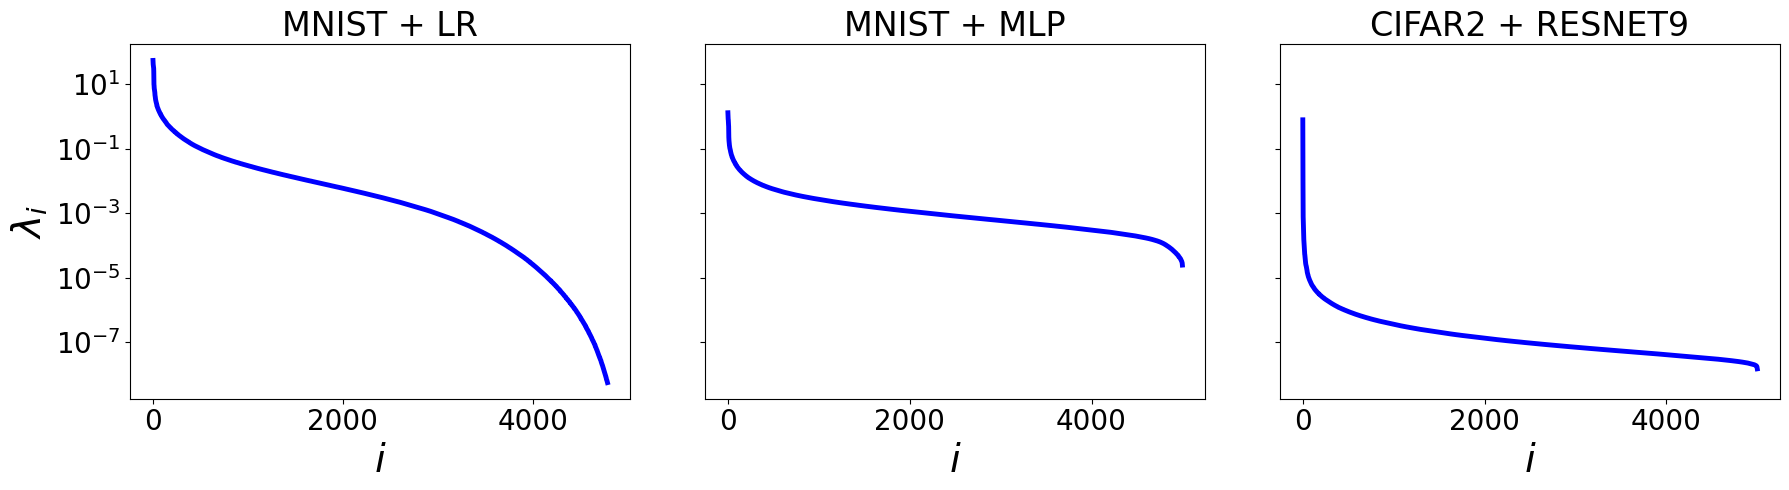

In [5]:
# =============================================================================
# Plot Combined Figures for Paper
# =============================================================================

spectrum_configs = [
    ("mnist", "lr"),
    ("mnist", "mlp"),
    ("cifar2", "resnet9"),
]

figures_dir = "./figures"
os.makedirs(figures_dir, exist_ok=True)
os.makedirs(f"{figures_dir}/spectrum_bounds", exist_ok=True)

# Combined bilinear form error plot (all 3 datasets side-by-side)
print("=" * 60)
print("Plotting Combined Bilinear Form Error")
print("=" * 60)
bilinear_combined_path = f"{figures_dir}/spectrum_bounds/bilinear_combined.pdf"
plot_bilinear_form_error_combined(spectrum_configs, save_path=bilinear_combined_path,
                                   figsize=(18, 5), lambda_colors=UNIFIED_LAMBDA_COLORS)

# Generate unified legend for the combined plot
print("\n" + "=" * 60)
print("Generating Unified Legend")
print("=" * 60)
legend_path = f"{figures_dir}/spectrum_bounds/bilinear_legend.pdf"
create_unified_legend(save_path=legend_path, figsize=(14, 0.6), fontsize=14)

# Combined spectrum plot (all 3 datasets side-by-side)
print("\n" + "=" * 60)
print("Plotting Combined Eigenvalue Spectrum")
print("=" * 60)
spectrum_combined_path = f"{figures_dir}/spectrum_bounds/spectrum_combined.pdf"
plot_spectrum_combined(spectrum_configs, save_path=spectrum_combined_path, figsize=(18, 5))